# Machine Learning in Python - Group Project 2

**Due Friday, April 21st by 16.00 pm.**

Alannah Hounat S2434943

## General Setup

In [42]:
# Add any additional libraries or submodules below
# Display plots inline
%matplotlib inline
# Data libraries
import pandas as pd
import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn modules
import sklearn
# extra added stuff
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LassoCV #for lasso model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import LabelEncoder

In [43]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

## 1. Introduction

This report focuses on analysing the hotel data set to gain insights and make informed decisions regarding possible cancellations and why they occur. The hotel data set contains information on various hotels such as the hotel type, the number guests, the type of room, the meal plan, and the cancellation status. The data set was collected to understand the booking patterns and behaviuors of hotel guests.

In this report, we used various approaches such as data visualisation, statistical analysis, and machine learning to draw conclusions and make informed decisions. The models in particular were investigated, the Lasso model, the Linear Regression model and the Random Forest Model. Based on our analysis, we were able to identify an optimal model, Fandom Forest. We were also able to identify key factors that influence hotel bookings and cancellations such as deposit type....

## 2. Exploratory Data Analysis and Feature Engineering

The main aim of this section is to help prepare our data prior to it being imput into a model. This section involves removing duplicate rows, dropping any missing data that cannot be imputed and converting the data types of some columns.

In [44]:
# read in the hotel.csv file
d = pd.read_csv("hotel.csv")

### Data Validation
The data used in this project is sourced from Antonio et al.[REF], which is based on real-world data. As such, it is possible that some data may be missing or incorrectly entered. In this section, we will implement data validation checks to address these inconsistencies.

### Addressing Missing Data
The first inconsistency we encountered was missing data in the "country", "agent", "company", and "children" columns. We cannot impute missing values for "children" as there is no logical way to estimate the number of children in a booking. However, for "country", "agent", and "company" columns, we will fill in the missing values with "no country", "no agent", and "no company", respectively.


In [45]:
# Check for missing values
print(d.isna().sum())

is_canceled                            0
hotel                                  0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Since there were some missing data in the 'children' column it would be wise to check 'adults' and 'children'. Logically there needs to be at leats one adult in each booking so first we checked if there were any bookings without adults. This resultsed in approximately 403 bookings that dont have adults. This then lead to the assumption that there could be entire booking with zero people. This lead to finding 180 with zero people in the booking. 
Thus, these values were removed.

To ensure the ccuracy of the data , we performed checks on the 'adults' and 'children' columns due to missing data in the 'children' column. We checked if there were any bookings without adults as logically, each booking should have at least one adult. This check revealed that around 403 bookings did not have any adults. We then hypothesised that there could be bookings with zero people, which led to the discovery of 180 such bookings. As these values were outliers, we removed them from the dataset to enhance the data quality.

In [46]:
# some sanity checks
# make sure that every booking has at least one adult
no_adults = d.loc[d['adults']==0,].count()[1]
print(f'there are {no_adults} bookings that dont have adults')

#check if theres any bookings with just no one 
no_people = d.loc[(d['adults']==0) & (d['children']==0) & (d['babies']==0),].count()[1]
print(f'there are {no_people} with zero people in the booking')

#remove these values, cant really be imputed in anyway
d = d[d['adults'] > 0]
d = d[(d['adults'] + d['children'] + d['babies']) > 0]

#fill the agent NULL values with 'no agent'
d['agent'] = d['agent'].fillna('no agent')

#fill the company NULL values with 'no company'
d['company'] = d['company'].fillna('no company')

#fill the country NULL values with 'no company'
d['country'] = d['country'].fillna('no country')

there are 403 bookings that dont have adults
there are 180 with zero people in the booking


After addressing the booking data with zero people, our attention turned to identifying any potential outliers in the dataset. Given the expected prevalence of bookings with 0, 1, 2, or 3 occupants, we decided to limit the y-axis to improve clarity and facilitate observations. The resulting plot revealed a couple of noteworthy outliers: one booking had around 10 babies, while another had about 9. Additionally, numerous bookings featured more than 10 adults, which could be explained by group reservations.

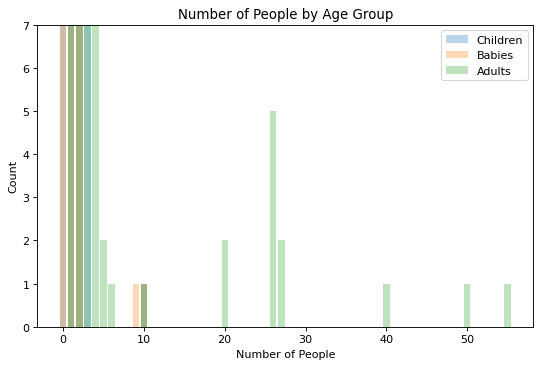

In [47]:
# Count the frequency of each value in the "children", "babies", and "adults" columns
children_counts = d['children'].value_counts()
babies_counts = d['babies'].value_counts()
adults_counts = d['adults'].value_counts()
# Sort the counts by index (number of children/babies/adults)
children_counts.sort_index(inplace=True)
babies_counts.sort_index(inplace=True)
adults_counts.sort_index(inplace=True)
# Create a bar chart with transparent bars
plt.bar(children_counts.index, children_counts.values, alpha=0.3, label='Children')
plt.bar(babies_counts.index, babies_counts.values, alpha=0.3, label='Babies')
plt.bar(adults_counts.index, adults_counts.values, alpha=0.3, label='Adults')
# Set the title and axis labels
plt.title('Number of People by Age Group')
plt.xlabel('Number of People')
plt.ylabel('Count')
# Set the y-axis range
plt.ylim(0,7 )
# Add a legend
plt.legend()
# Show the plot
plt.show()

Therefor based on the previous plot we remove any unreasonable bookings.

In [48]:
#remove one outliers for babies
d = d[d['babies'] < 9] 
# remove one outlier for children
d = d[d['children'] < 9]

To ensure data accuracy, our team conducted a check for duplicate bookings in the dataset. It was discovered that there were 32234 duplicate rows, which were subsequently removed from the dataset.

In [49]:
#now check for duplicates
duplicate_rows = d[d.duplicated()]
print(f'There are {duplicate_rows.shape[0]} duplicate rows in the dataset.')
#drop duplicate rows, keeping the last occurrence
d = d.drop_duplicates(keep='last')
#since sc and undefined are the same (in the project details) change them
d.loc[d.meal=='Undefined','meal'] = 'SC'

There are 32234 duplicate rows in the dataset.


After removing the extreme values, outliers, and duplicates, we can conclude that the data in the 'adults', 'children', and 'babies' columns is clean. To summarise this data, we created a new column called "total_guests" which represents the total number of guests in each booking.

In [50]:
#safe to say the adults,children and babies are cleaned data 
#total number of guests column is handier than them being separated
d['total_guests'] = d[['adults','children','babies']].sum(axis=1)
#drop the people
d = d.drop(columns=['adults', 'children', 'babies'])

##### Converting data types 
Converting the string column to datetime format is an important step as it allows us to work with dates and times more easily. We can perform various operations such as sorting, extracting specific components and will pose helpful when creating plots.

In [51]:
# Combine the three columns into a single string column
d['date'] = d['arrival_date_year'].astype(str) + '-' + d['arrival_date_month'] + '-' + d['arrival_date_day_of_month'].astype(str)
# Convert the string column to datetime format
d['date'] = pd.to_datetime(d['date'], format='%Y-%B-%d')

### Feature Exploration on the data

After cleaning the data, it is important to perform further investigation to gain a deeper understanding of the dataset. This can include exploring relationships between variables, identifying patterns or trends, and detecting any outliers or anomalies. Further investigation can also involve conducting statistical analyses or creating visualisations to better understand the data.

By performing further investigation, we can gain insights into the data that may not have been immediately apparent from initial observations. These insights can then inform our decision-making process and help us draw meaningful conclusions about the dataset. Additionally, further investigation can help us identify any potential issues or limitations with the data, which can be addressed in subsequent analysis. Overall, further investigation is a crucial step in the data analysis process and can greatly improve the quality and reliability of our findings.

It must be noted that because the data set is so vast we will only observe a random sample of our data.

### Analysis of the Pairplot

The above plot displays pairwise relationships between variables in a dataset. It is a grid of scatter plots where each row and column in the grid represents a variable, and each cell in the grid represents a scatter plot of the relationship between the variables in that row and column.

The diagonal plots show the distribution of each variable, while the off-diagonal plots show the relationship between two variables. The scatter plots in the off-diagonal plots show the relationship between the variables, with each dot representing a data point.

We can observe some slight clustering of data in some plots, but nothing too obvious. Specifically, we note this with the adr vs. lead_time plot. Additionally, there are some outliers that are noticeable in most of the plots. We can also observe some non-linear correlations as well. These findings suggest that further investigation is needed to better understand the underlying patterns in the data.

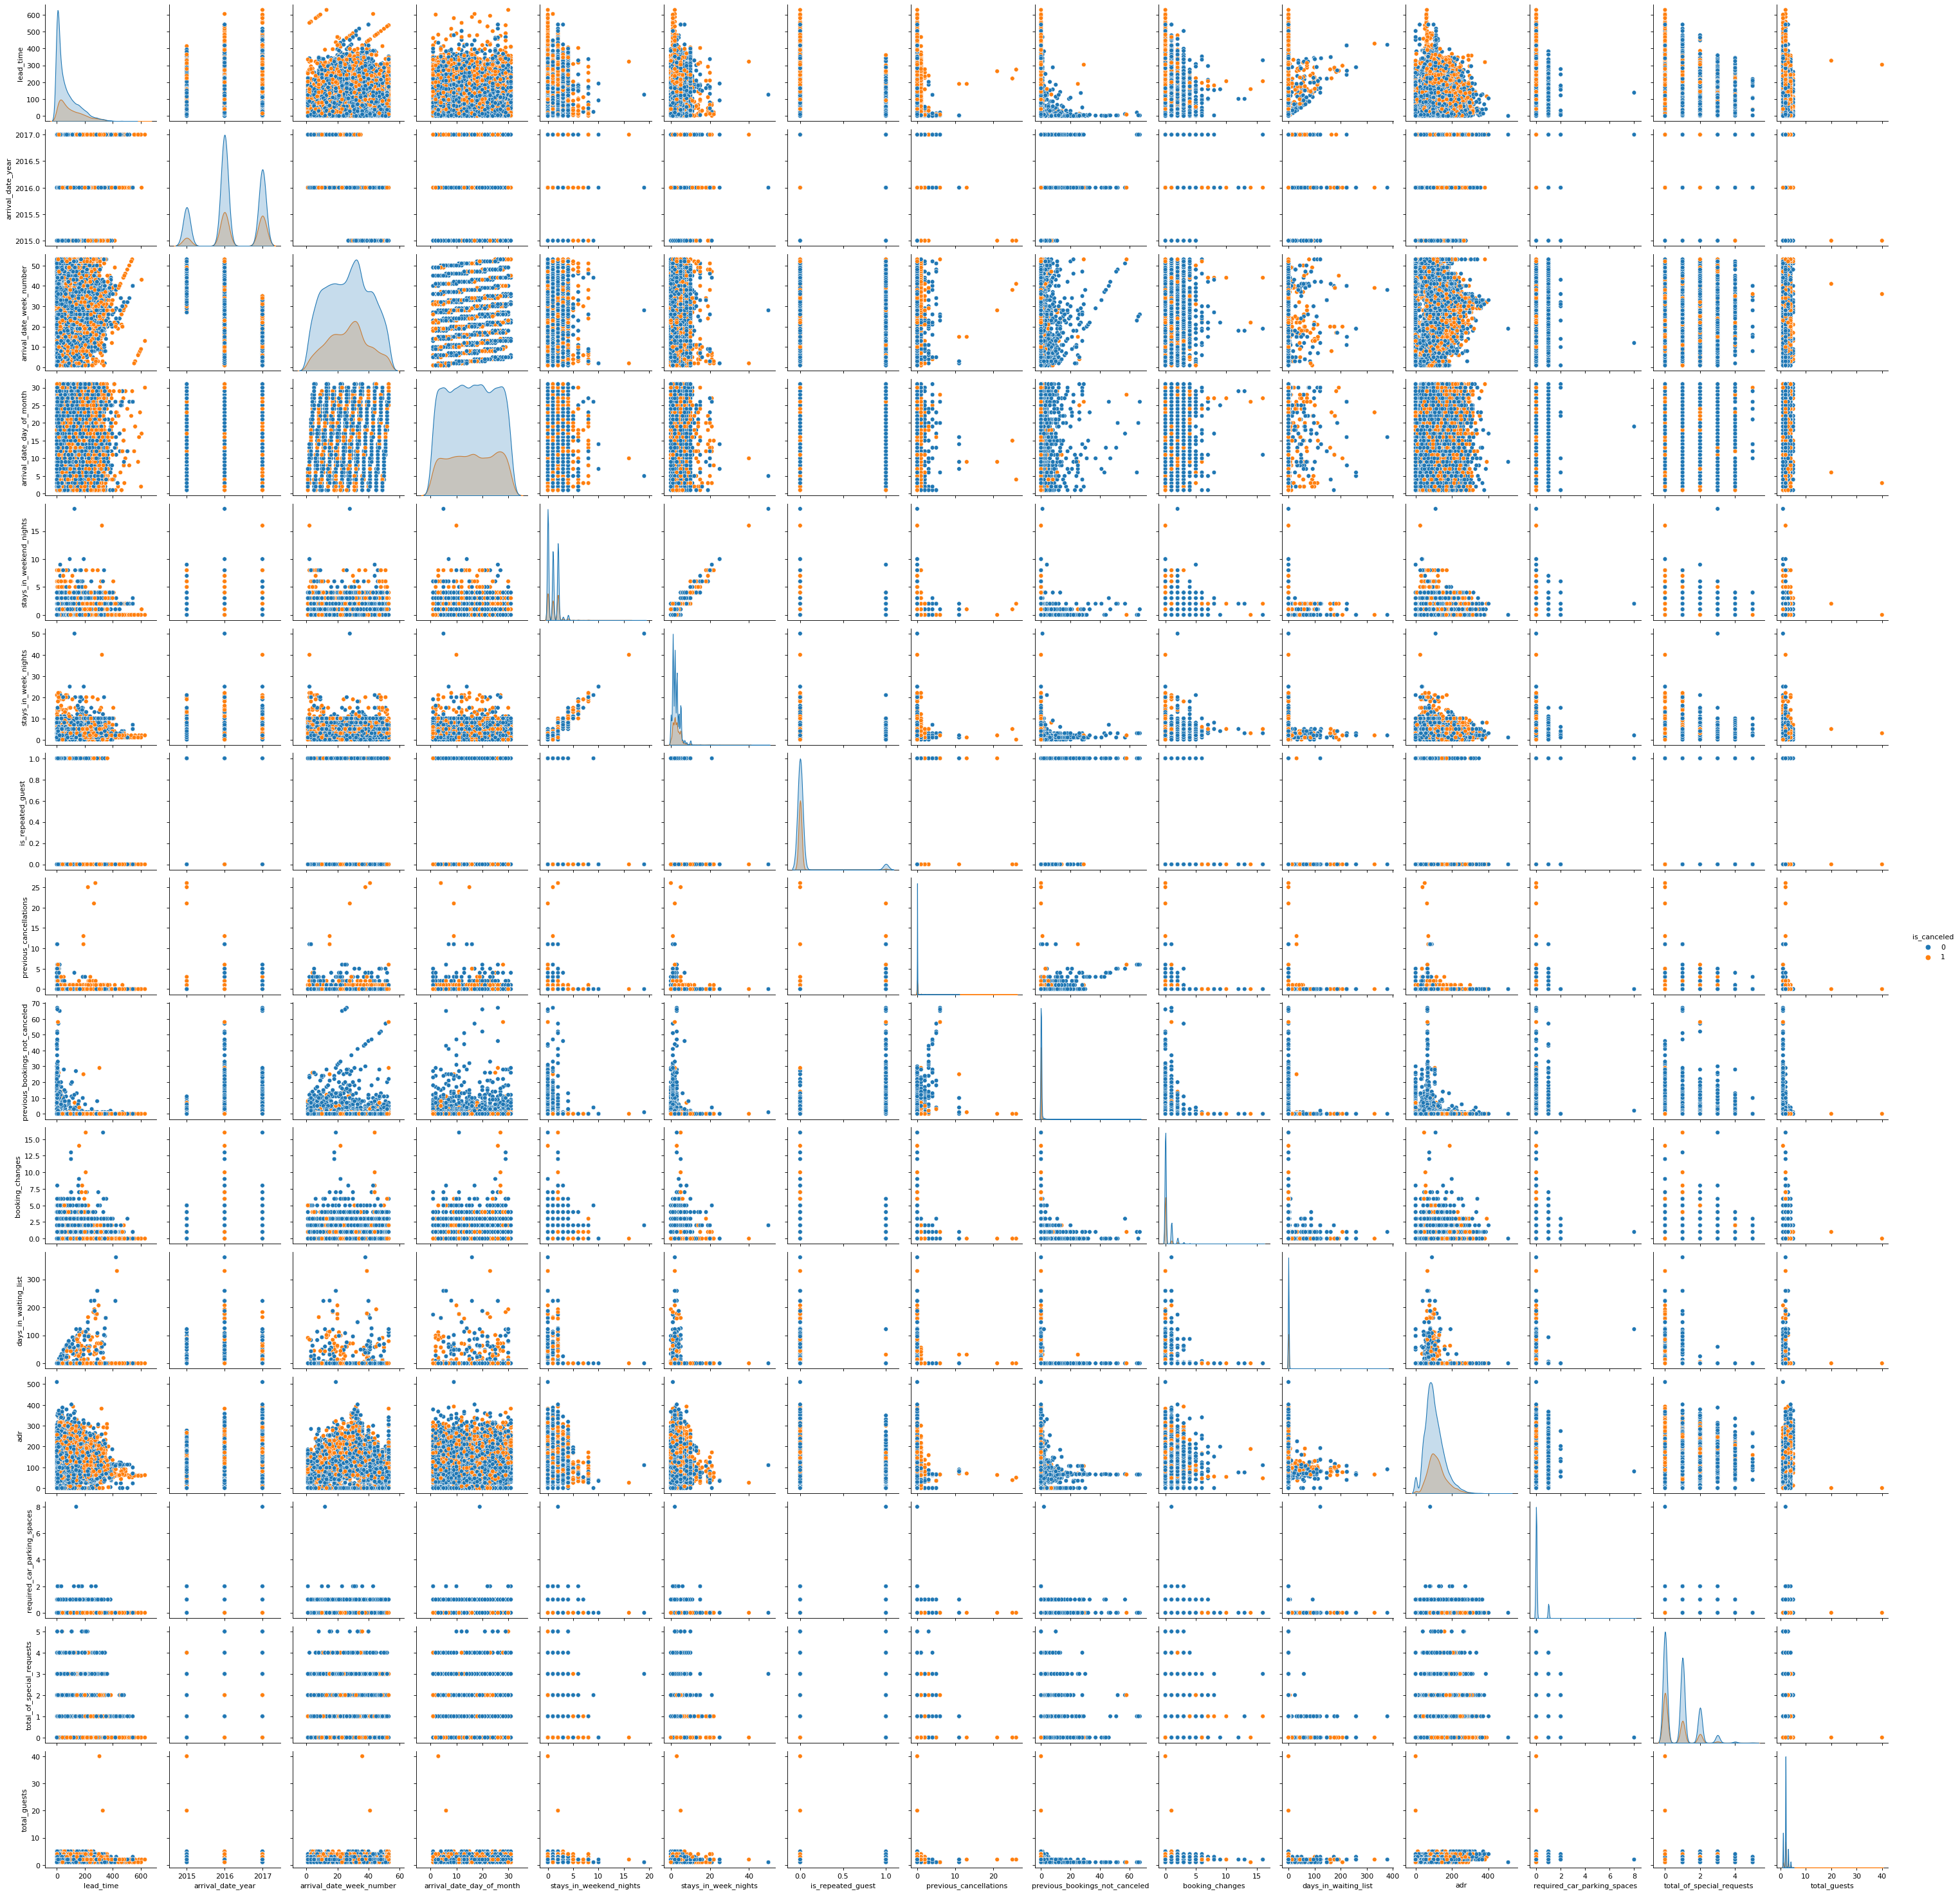

In [52]:
#30% sample size
sample_size = int(len(d) * 0.3)

# get random sample
sampled_d = d.sample(n=sample_size, random_state=42)

# plot pairplot using randomly sampled data
sns.pairplot(hue = 'is_canceled', data = sampled_d)

##### Number of cancelled bookings

First we wanted to observe really how many rooms are cancelled and if there is a particular time that this could occur. From the plot below we can see that May 2017 contains the most cancellations

### Analysis of plots below

#### 'Cancelled and Not Cancelled Bookings by Hotel Type'

The plots show that the city hotel has a higher number of cancellations compared to the resort hotel, which is somewhat surprising. To get a better understanding of the cancellation percentages for each hotel type, we calculated the percentage of cancellations. We found that approximately 30% of the bookings made at the city hotel were cancelled, whereas only 23% of bookings made at the resort hotel were cancelled. This result is somewhat counterintuitive, as one would expect that the higher cost associated with city hotels would discourage people from cancelling their bookings.

#### 'Cancelled vs Not Cancelled Bookings by Month'

The plotted data shows the number of cancellations by month. To obtain the exact percentage, we calculated the cancellation percentage per month and sorted them by the highest percentage. This revealed that the months of May to August 2017 had the highest cancellation rates. This insight gives us a good understanding of cancellation trends.

Next, we wanted to determine the most common month for cancellations over the entire period of 2015-2017. The results indicated that August had the highest number of cancellations, with 32% of bookings being cancelled. July followed closely behind with 31.369.

/tmp/ipykernel_95/303523018.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(cancelled_by_month.index, rotation=90)


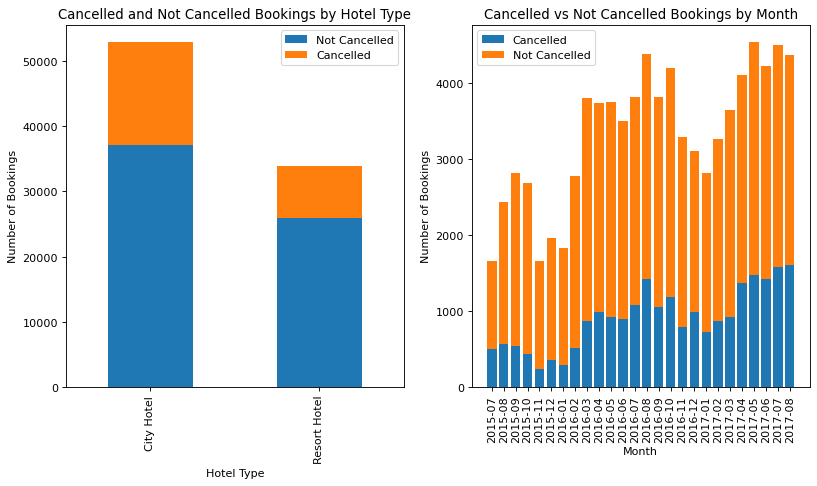

In [53]:
# Filter the data to get cancelled and not cancelled bookings separately
cancelled_bookings = d[d['is_canceled'] == 1]
not_cancelled_bookings = d[d['is_canceled'] == 0]

# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Create a crosstab of hotel type and cancellation status
hotel_crosstab = pd.crosstab(d['hotel'], d['is_canceled'])

# Create a stacked bar chart for cancelled and not cancelled bookings by hotel type
hotel_crosstab.plot(kind='bar', stacked=True, ax=ax1)

# Set the plot labels and legend for the first subplot
ax1.set_title('Cancelled and Not Cancelled Bookings by Hotel Type')
ax1.set_xlabel('Hotel Type')
ax1.set_ylabel('Number of Bookings')
ax1.legend(['Not Cancelled', 'Cancelled'])

# Group bookings by month and count the number of bookings in each group
cancelled_by_month = cancelled_bookings.groupby(cancelled_bookings['date'].dt.strftime('%Y-%m'))['is_canceled'].count()
not_cancelled_by_month = not_cancelled_bookings.groupby(not_cancelled_bookings['date'].dt.strftime('%Y-%m'))['is_canceled'].count()

# Create stacked bar chart for cancelled vs not cancelled bookings by month
ax2.bar(cancelled_by_month.index, cancelled_by_month, label='Cancelled')
ax2.bar(not_cancelled_by_month.index, not_cancelled_by_month, bottom=cancelled_by_month, label='Not Cancelled')
ax2.set_xticklabels(cancelled_by_month.index, rotation=90)
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Bookings')
ax2.set_title('Cancelled vs Not Cancelled Bookings by Month')
ax2.legend()

plt.show()


In [54]:
# Calculate the percentage of canceled rooms for city hotel
city_canceled_percentage = (d.loc[(d["hotel"] == "City Hotel") & (d["is_canceled"] == 1), "is_canceled"].count() / d.loc[d["hotel"] == "City Hotel", "is_canceled"].count()) * 100
print("Percentage of canceled rooms for City Hotel:", city_canceled_percentage)
# Calculate the percentage of canceled rooms for resort hotel
resort_canceled_percentage = (d.loc[(d["hotel"] == "Resort Hotel") & (d["is_canceled"] == 1), "is_canceled"].count() / d.loc[d["hotel"] == "Resort Hotel", "is_canceled"].count()) * 100
print("Percentage of canceled rooms for Resort Hotel:", resort_canceled_percentage)
# Blank line to separate outputs
print()
# Group bookings by month and count the total number of bookings and cancelled bookings in each group
bookings_by_MMYY= d.groupby(d['date'].dt.strftime('%Y-%m'))['is_canceled'].agg([('total_bookings', 'count'), ('cancelled_bookings', 'sum')])
# Calculate the percentage of bookings cancelled in each month
bookings_by_MMYY['cancelled_percentage'] = (bookings_by_MMYY['cancelled_bookings'] / bookings_by_MMYY['total_bookings']) * 100
bookings_by_MMYY_sorted = bookings_by_MMYY.sort_values('cancelled_percentage', ascending=False)
print(bookings_by_MMYY_sorted)

Percentage of canceled rooms for City Hotel: 29.835079623255282
Percentage of canceled rooms for Resort Hotel: 23.29357581483231

         total_bookings  cancelled_bookings  cancelled_percentage
date                                                             
2017-08            4372                1602             36.642269
2017-07            4510                1587             35.188470
2017-06            4223                1426             33.767464
2017-04            4108                1375             33.471276
2017-05            4543                1479             32.555580
2016-08            4380                1423             32.488584
2016-12            3114                 991             31.824021
2015-07            1662                 502             30.204573
2016-07            3819                1078             28.227285
2016-10            4195                1183             28.200238
2016-09            3822                1054             27.577185
2017-02     

In [55]:
# Group bookings by month and count the total number of bookings and cancelled bookings in each group
bookings_by_month = d.groupby(d['date'].dt.strftime('%m'))['is_canceled'].agg([('total_bookings', 'count'), ('cancelled_bookings', 'sum')])
# Calculate the percentage of bookings cancelled in each month
bookings_by_month['cancelled_percentage'] = (bookings_by_month['cancelled_bookings'] / bookings_by_month['total_bookings']) * 100
bookings_by_month_sorted = bookings_by_month.sort_values('cancelled_percentage', ascending=False)
# Print the resulting dataframe
print(bookings_by_month_sorted)

      total_bookings  cancelled_bookings  cancelled_percentage
date                                                          
08             11186                3587             32.066869
07              9991                3167             31.698529
04              7850                2369             30.178344
06              7724                2329             30.152771
05              8291                2397             28.910867
12              5073                1352             26.650897
03              7457                1803             24.178624
09              6638                1601             24.118710
10              6881                1617             23.499491
02              6051                1392             23.004462
01              4653                1020             21.921341
11              4951                1031             20.824076


## Analysis of cancellations by repeated guests

It is a positive sign that around 92.29% of previous repeated guests have not cancelled their bookings, indicating a high level of satisfaction and loyalty among this group. Furthermore, the data reveals that guests who opted for a non-refundable deposit are significantly less likely to cancel their reservation (94.59%) than those who chose a refundable deposit (75.7%) or did not pay a deposit at all (73.51%). This finding suggests that requiring guests to make a deposit for their room may serve as a useful deterrent against cancellations, and can be a helpful strategy for hotel management to reduce the number of cancellations.

In [56]:
# Calculate the percentage of cancellations by repeated guests
repeated_guest_cancellations = d[d['is_repeated_guest'] == 1]['is_canceled'].value_counts(normalize=True) * 100
print('Percentage of cancellations by repeated guests:')
print(repeated_guest_cancellations)
print()
# Calculate the percentage of cancellations by deposit type
deposit_cancellations = d.groupby('deposit_type')['is_canceled'].value_counts(normalize=True) * 100
print('Percentage of cancellations by deposit type:')
print(deposit_cancellations)

Percentage of cancellations by repeated guests:
0    92.296252
1     7.703748
Name: is_canceled, dtype: float64

Percentage of cancellations by deposit type:
deposit_type  is_canceled
No Deposit    0              73.514984
              1              26.485016
Non Refund    1              94.591937
              0               5.408063
Refundable    0              75.700935
              1              24.299065
Name: is_canceled, dtype: float64


## Analysis of Cancellation by Distribution Channel

Based solely on the plot, it appears that a portion of customers who booked through TA/TO ended up cancelling their reservations. This finding suggests that there may be issues with the services provided by these travel agencies or tour operators that are causing customers to cancel their bookings.

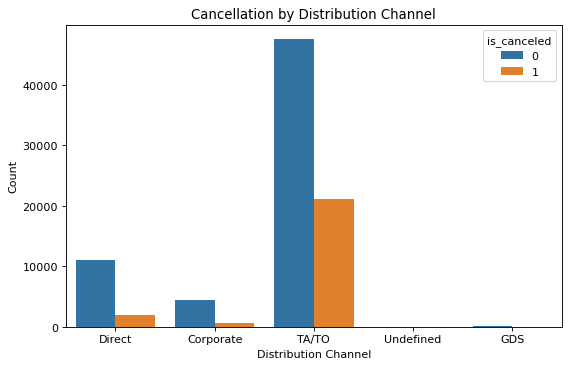

In [57]:
# cancellations and how people booked

sns.countplot(x="distribution_channel", hue="is_canceled", data=d)
plt.title("Cancellation by Distribution Channel")
plt.xlabel("Distribution Channel")
plt.ylabel("Count")
plt.show()

### Distribution of ADR Values

ADR stands for Adjusted Daily Rate, which refers to the average amount paid per day for a room. We plotted the distribution of ADR values to gain insights into the cost of bookings. However, we discovered that 1470 of the ADR values for bookings that were not cancelled are zero, which is unexpected because if a room was not cancelled, it means the customer must have paid for the room. On the other hand, we observed that some of the cancelled rooms had non-zero ADR values, indicating that these bookings likely had non-refundable deposits.

We explored the possibility of imputing the missing data by extracting the "assigned_room_type" and "adr" values from other columns. However, we identified two potential issues with this approach. Firstly, it could introduce bias into our model. Secondly, the ADR value could include additional charges like cleaning fees, which would make it inaccurate to impute the missing values solely based on "assigned_room_type" and "adr" columns.

Therefore, we decided to retain the missing data, as discarding it entirely may compromise the accuracy of our model, while imputing it using incomplete or biased information could also lead to inaccurate results.

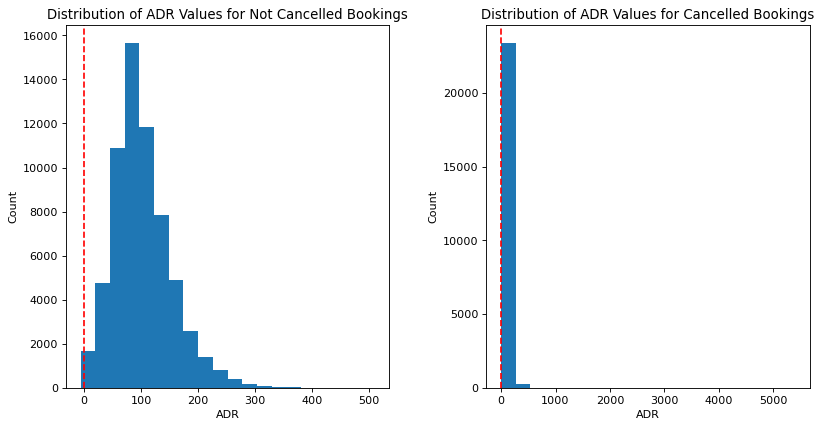

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

# Plot a histogram of the 'ADR' column for not cancelled bookings
ax1.hist(d.loc[d['is_canceled'] == 0, 'adr'], bins=20)
ax1.axvline(x=0, color='r', linestyle='--')
ax1.set_title('Distribution of ADR Values for Not Cancelled Bookings')
ax1.set_xlabel('ADR')
ax1.set_ylabel('Count')

# Plot a histogram of the 'ADR' column for cancelled bookings
ax2.hist(d.loc[d['is_canceled'] == 1, 'adr'], bins=20)
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_title('Distribution of ADR Values for Cancelled Bookings')
ax2.set_xlabel('ADR')
ax2.set_ylabel('Count')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [59]:
# Filter the data to include only "not cancelled" bookings and where ADR is 0
zero_adr_not_cancelled = d[(d['is_canceled'] == 0) & (d['adr'] == 0)]

# Get the count of rows in the filtered data
count_zero_adr_not_cancelled = len(zero_adr_not_cancelled)

print("The number of 0 ADR values in 'not cancelled' bookings is:", count_zero_adr_not_cancelled)

The number of 0 ADR values in 'not cancelled' bookings is: 1470


### Analysis of Previous Cancellations

The bar chart illustrates that the majority of the bookings in the dataset had few or no previous cancellations. Given that the dataset spans over a period of three years, it would be unlikely for there to be an excessive number of cancellations. However, the maximum number of previous cancellations for both hotel types was 26, which is considered unrealistic.

To gain more insights into the data, we analysed the summary statistics, which revealed limited information due to a high number of zero values. Therefore, we removed any previous cancellation value below five, assuming that five cancellations over a five-year period would be a reasonable threshold.

The anlysis of this in continued below

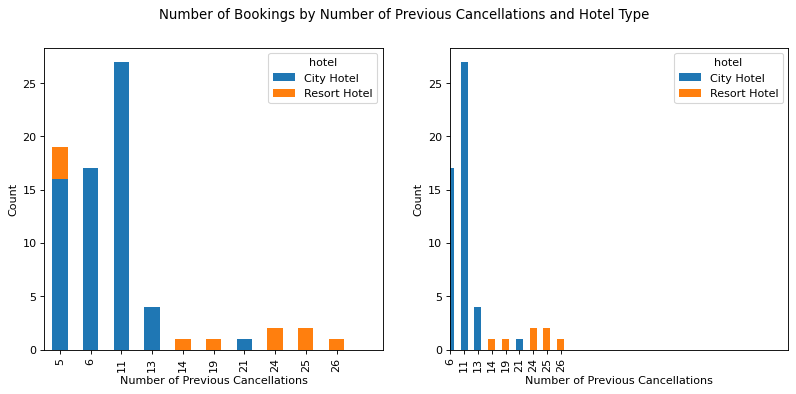

In [60]:
# Filter the data to exclude bookings with 0 previous cancellations
d_filtered = d[d['previous_cancellations'] > 4]

# Group the data by the number of times a booking was previously cancelled and the hotel type
cancel_counts = d_filtered.groupby(['previous_cancellations', 'hotel'])['hotel'].count().unstack()

# Create a figure with two subplots, side by side
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Plot a stacked bar chart of the data for both subplots
cancel_counts.plot(kind='bar', stacked=True, ax=axs[0])
cancel_counts.plot(kind='bar', stacked=True, ax=axs[1])

# Set the title and labels for both subplots
fig.suptitle('Number of Bookings by Number of Previous Cancellations and Hotel Type')
axs[0].set_xlabel('Number of Previous Cancellations')
axs[0].set_ylabel('Count')
axs[1].set_xlabel('Number of Previous Cancellations')
axs[1].set_ylabel('Count')

# Set different x-axis limits for the two subplots
axs[0].set_xlim(-0.5, 10.5)
axs[1].set_xlim(1, 25.5)

# Show the plot
plt.show()

In [61]:
# Group the data by hotel type and calculate the mean, median, standard deviation, maximum, minimum, and quartiles of previous cancellations
stats_by_hotel_type = d.groupby('hotel')['previous_cancellations'].agg(['mean', 'median', 'std', 'min', 'max', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
# Rename the quartile columns to be more descriptive
stats_by_hotel_type = stats_by_hotel_type.rename(columns={'<lambda_0>': 'quart1', '<lambda_1>': 'quart3'})
#title for data table
print("Summary statistics for number of cancellations based on previous bookings")
# Print the resulting statistics
print(stats_by_hotel_type)
print()
#Group the filtered data by hotel type and calculate the mean, median, standard deviation, maximum, minimum, and quartiles of previous cancellations
stats_by_hotel_type_filtered = d_filtered.groupby('hotel')['previous_cancellations'].agg(['mean', 'median', 'std', 'min', 'max', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
#Rename the quartile columns to be more descriptive
stats_by_hotel_type_filtered = stats_by_hotel_type_filtered.rename(columns={'<lambda_0>': 'quart1', '<lambda_1>': 'quart3'})
# title for data table
print("Summary statistics for number of cancellations based on previous bookings: excluding obvious values")
#Print the resulting statistics
print(stats_by_hotel_type_filtered)

Summary statistics for number of cancellations based on previous bookings
                  mean  median       std  min  max  quart1  quart3
hotel                                                             
City Hotel    0.035670     0.0  0.374027    0   21     0.0     0.0
Resort Hotel  0.021847     0.0  0.363434    0   26     0.0     0.0

Summary statistics for number of cancellations based on previous bookings: excluding obvious values
                   mean  median       std  min  max  quart1  quart3
hotel                                                              
City Hotel     8.492308     6.0  3.326612    5   21    6.00   11.00
Resort Hotel  17.200000    21.5  9.138441    5   26    7.25   24.75


### Analysis of summary statistics 

We can observe  that there are outliers in both hotels for the maximum number of cancellations, since both the City Hotel and Resort Hotel have maximum values that are more than 1.5 times the interquartile range (IQR) above the third quartile (Q3). For example in the City Hotel, the maximum value of 21 is more than 1.5 times the IQR (which is 5) above the Q3 of 11. Similarly, in the Resort Hotel, the maximum value of 26 is more than 1.5 times the IQR (which is 17.5) above the Q3 of 24.75.

Therefor we believe it would be wise to remove any values that are significantly higher than the median and quartile values. Once again, while imputing the missing data could be a reasonable solution, it carries the risk of introducing bias into our model, which we want to avoid.

In [62]:
# removing outliers in cancellations

# Calculate the median based off of d_filtered by hotel type
median_by_hotel = d_filtered.groupby('hotel')['previous_cancellations'].median()

# Loop over each hotel type and remove outliers from d
for hotel_type, median_value in median_by_hotel.items():
    d = d[~((d['hotel'] == hotel_type) & (d['previous_cancellations'] > median_value))]

## Correlation Plot 

Like the Pairplot, the correlation plot is another useful way to observe the relationships between all the variables in the dataset. It provides a visual representation of the correlation between each pair of features, indicating how strongly they are related to each other

### Analysis of Corrolation

The plots below show the correlation between all the variables. There are two correlation plots, one for the cancelled bookings and one for not cancelled bookings.

We can see that required_car_parking_spaces, lead_time, adr, and total_of_special_requests seem to be most correlated with cancelled bookings, but to see this more simply we display the correlations in order of most correlated to least.

Based on the correlation coefficients we provided, the features that show a moderate to strong correlation with the outcome variable "is_canceled" and may be useful for predicting cancellations are: lead_time, adr, required_car_parking_spaces, total_of_special_requests, booking_changes, is_repeated_guest, stays_in_week_nights, and previous_cancellations.
Thus, we can conclude that these are the features that we may see keept in our model.

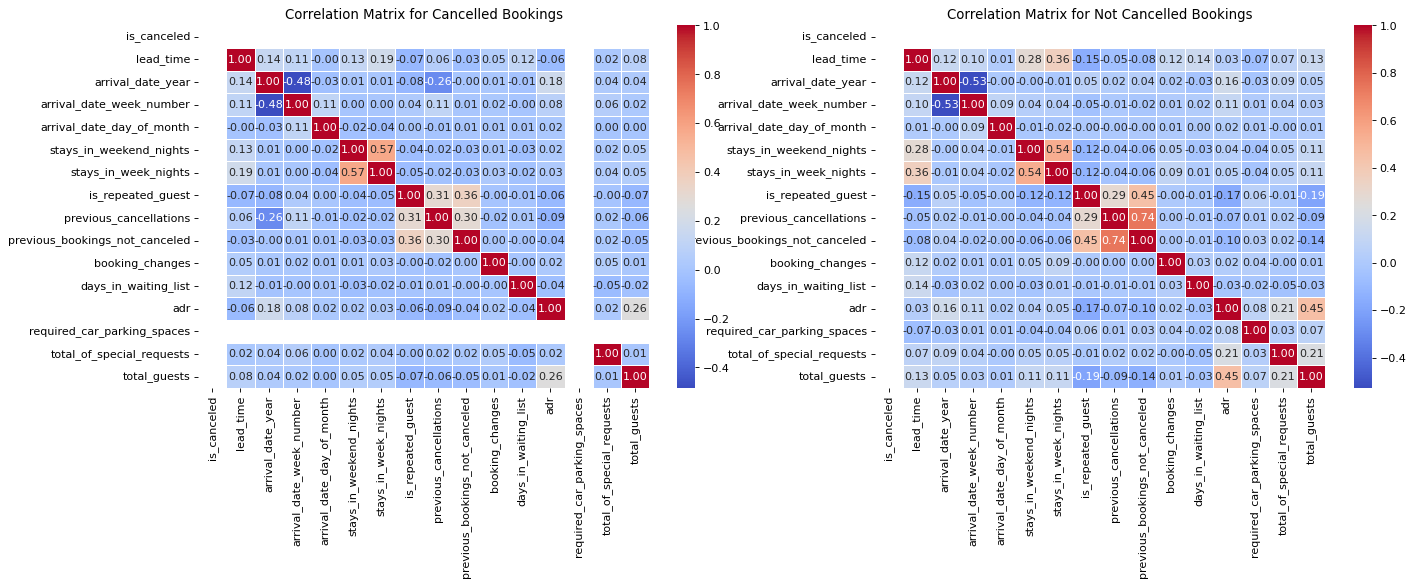

In [63]:
# Filter the data to include only cancelled and not cancelled bookings
cancelled_bookings = d[d['is_canceled'] == 1]
not_cancelled_bookings = d[d['is_canceled'] == 0]
# Calculate correlation matrices
corr_cancelled = cancelled_bookings.corr()
corr_not_cancelled = not_cancelled_bookings.corr()

# Create subplots for the two heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Create heatmaps
sns.heatmap(corr_cancelled, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
sns.heatmap(corr_not_cancelled, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])

# Set titles and rotate x-axis labels
axes[0].set_title('Correlation Matrix for Cancelled Bookings')
axes[1].set_title('Correlation Matrix for Not Cancelled Bookings')
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Show plots
plt.show()

In [64]:
#which features have the strongest relationships with cancellation
corr_relation = d.corr()["is_canceled"]
corr_relation.abs().sort_values(ascending=False)

is_canceled                       1.000000
required_car_parking_spaces       0.183858
lead_time                         0.181938
adr                               0.129291
total_of_special_requests         0.119064
total_guests                      0.100385
booking_changes                   0.092231
arrival_date_year                 0.089426
is_repeated_guest                 0.088201
stays_in_week_nights              0.084484
previous_cancellations            0.075227
stays_in_weekend_nights           0.061268
previous_bookings_not_canceled    0.051704
arrival_date_day_of_month         0.005505
days_in_waiting_list              0.001667
arrival_date_week_number          0.001044
Name: is_canceled, dtype: float64

### One Hot Coding

The last step before model fitting and tuning is to implement One hot coding.
One-hot encoding is a technique used in machine learning to convert categorical variables into a format that can be used by models that expect numerical data. In the context of countries, in our data set we have a "country" column that contains categorical data. In this column, we have various countries listed such as "PRT", "GBR" etc. (from plots)

However, most machine learning models work with numerical data, so we need to find a way to represent these categorical data as numbers. This is where one-hot encoding comes in. One-hot encoding converts each unique category value into a binary vector, where each vector has a length equal to the number of unique categories. For example, if we have four unique countries in our dataset, the one-hot encoded vectors for each country would have a length of four.

In [65]:
d_encoded = pd.get_dummies(d)
d_encoded['month'] = pd.to_datetime(d_encoded['date']).dt.month
d_encoded = d_encoded.drop('date', axis=1)


## 3. Model Fitting and Tuning

The three types of models that will be tried are the Lasso regression with cross fold validation, Linear regression and Random Forest. Below we will define them simply.

### What is Linear Regression?
A linear regression model is a statistical method used to analyse the relationship between two variables by fitting a straight line to the data. It is commonly used to predict or estimate the value of one variable based on the value of another. The line is determined by finding the best-fitting line that minimises the difference between the predicted values and the actual values. The model assumes that there is a linear relationship between the variables, meaning that as one variable increases, the other variable also increases/decreases at a constant rate.

### What is Lasso?
Lasso regression helps to select important features and prevents overfitting by shrinking the coefficients of less important features towards zero. This results in a simpler model with fewer features, which can be easier to interpret and generalise to new data.
Cross-validation is a technique used to evaluate how well a model will perform on new data. It involves splitting the data into multiple parts (folds) and training the model on some folds while testing it on others. This helps to prevent overfitting by providing an estimate of how well the model will generalise to new data.

#### Crossfold Validation

Since our data set is big we can afford to only have 5 folds, having anymore may corrupt bias.In a Lasso model with cross-validation, the aim is to find the best value of the regularisation parameter (alpha) that balances the model's complexity and accuracy. This is done by trying different values of alpha and evaluating the model's performance on each fold of the data. The value of alpha that produces the best performance is chosen as the optimal value for the model.


### What is Random Forest?
A random forest model is an algorithm that uses multiple decision trees on randomly selected subsets of the data and then aggregating the results to make a final prediction. 
Each decision tree in the random forest is trained on a random subset of the data, and the final prediction is based on the average or majority vote of the predictions made by all the decision trees. This approach helps to reduce overfitting and improve the accuracy and robustness of the model.

#### Splitting the data
Below we will use a 70/30 split on the data. 70% of the data will be used to train our models while the other 70% will be used to test our model. A 70/30 split was chosen due to how vast our data is, using a smaller amount of data to train the model could result in underfitting, while using a larger amount of data for testing could result in overfitting. Therefore, a 70/30 split strikes a good balance between having enough data to train the model and having enough data to evaluate its performance, while also helping to prevent overfitting and underfitting.


In [66]:
# first split the data using a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(d_encoded.drop(['is_canceled'], axis=1), d_encoded['is_canceled'], test_size=0.3, random_state=42)


In [67]:
#Function from week 5 workshop, unchanged

def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

### Rejected models

#### Lasso
Based on the analysis of plots, it appears that the Lasso model may not be the best fit for the data. The actual vs fitted plot shows that the model is not accurately capturing the variability in the data, while the fitted vs residual plot indicates that the model is not predicting the outcome variable well, possibly due to a non-linear relationship between the predictors and outcome variable. Additionally, the RMSE value of 0.3884 suggests that the model's predictions are off by about 0.3884 units on average, and the R^2 value of 0.2361 indicates that the model explains only 23.61% of the variation in the outcome variable. 

#### Linear Regression
Based on the analysis of plots, the linear regression model was rejected because it is not accurately capturing the variability in the data and is systematically overestimating or underestimating the outcome variable, as seen in the Actual vs Fitted graph. Additionally, the Fitted vs Residual graph suggests that the model is not capturing the variability of the data well and may not be taking into account non-linear relationships between the predictors and the outcome variable. The high MSE and RMSE values of 4.0812810615692565e+21 and 63884904802.067726, respectively, indicate that, on average, the predicted values are far from the actual values. Finally, the extremely low Rsq value of -2.0668720956528052e+22 indicates that the model is performing very poorly in explaining the variability of the outcome variable and is even worse than just predicting the mean of the outcome variable.

Taken together, these results suggest that the Lasso model and the Linear regression model are not be performing well and that other modles should be considered to ensure better predictions.

## Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)

# Define hyperparameters to tune
rf_params = {
    'n_estimators': [1, 10, 100, 1000],
    'max_depth': [2, 3, 4]
}

# Create random forest classifier
rf_model = RandomForestClassifier(max_depth=2, random_state=42)

# Perform grid search cross-validation to find best hyperparameters
model = GridSearchCV(rf_model, rf_params, cv=5, scoring='accuracy')
model.fit(X_train, y_train)

# Train model with best hyperparameters
rf_model = model.best_estimator_
rf_model.fit(X_train, y_train)

# Evaluate model on test set
score = rf_model.score(X_test, y_test)
print(f'Test set accuracy score: {score}')

Test set accuracy score: 0.7401683773497867


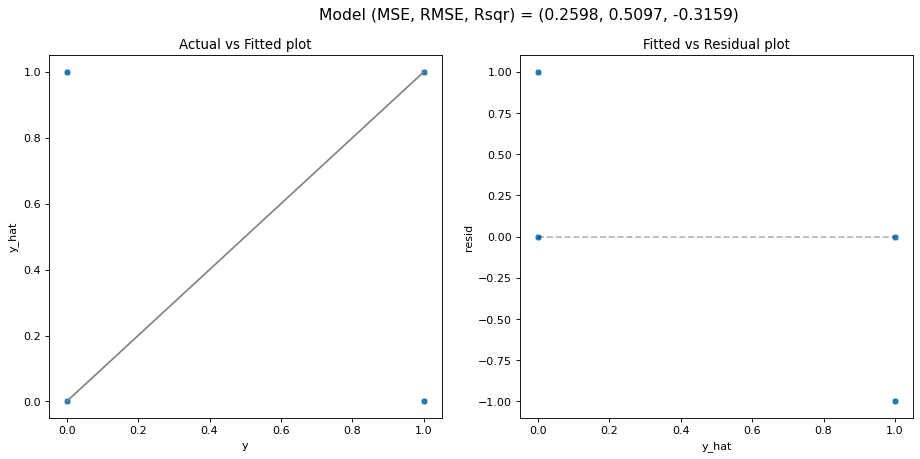

(0.25983162265021337, 0.5097368170440638, -0.3158582374560195)

In [69]:
model_fit(rf_model, X_test, y_test, plot = True)

### Analysis of plots

**Actual vs fitted** : This is a plot that shows how well the model is predicting the actual values in the test set. The diagonal line in the plot represents a perfect prediction, where the predicted value is exactly the same as the actual value. The fact that the plot shows a diagonal line going from (0,0) to (1,1) means that the model is predicting the test set values reasonably well.

**Fitted vs Residual** :  This is a plot that shows the relationship between the predicted values and the residuals (the difference between the predicted value and the actual value) in the test set. A good model will have residuals that are randomly distributed around zero. The fact that the plot shows a horizontal line at y=0 means that the model is doing a good job of predicting the test set values.

**MSE** : This is a measure of how well the model is predicting the test set values. It calculates the average of the squared differences between the predicted and actual values. A lower MSE value indicates a better fit between the predicted and actual values. The value of 0.2598 indicates that the model is not accurately predicting the response variable but does a significantly better job than our previous two models. 

**RMSE** : The value of 0.5097 indicates that the model has a high degree of error in its predictions, this ranks 2nd with respect to the other models.

**Rsqr** : The negative value of -0.3158 indicates that the model is performing worse than simply predicting the mean of the response variable.

Despite encountering some issues, the RandomForest model seems to be the best contender. Our next step is to examine important variables and explore ways to improve this model.

In [70]:
#Select features that have non-zero importance values
selected_features_rf = X_train.columns[rf_model.feature_importances_ != 0]
#Get the coefficients
coef_rf = rf_model.feature_importances_[rf_model.feature_importances_ != 0]
# sort indices in descending order of coefficients
sorted_idx_rf = np.argsort(-coef_rf)  

print("Selected features and coefficients (ordered by coefficient value):")
for feature, coef in zip(selected_features_rf[sorted_idx_rf], coef_rf[sorted_idx_rf]):
    if coef != 0:
        print(feature + ":", coef)


Selected features and coefficients (ordered by coefficient value):
deposit_type_Non Refund: 0.45090068275713235
lead_time: 0.3357974776473293
stays_in_week_nights: 0.1537306503336302
hotel_Resort Hotel: 0.05139419225172708
distribution_channel_TA/TO: 0.004481944708638037
previous_bookings_not_canceled: 0.003683692359692238
agent_29.0: 1.1359941850824096e-05


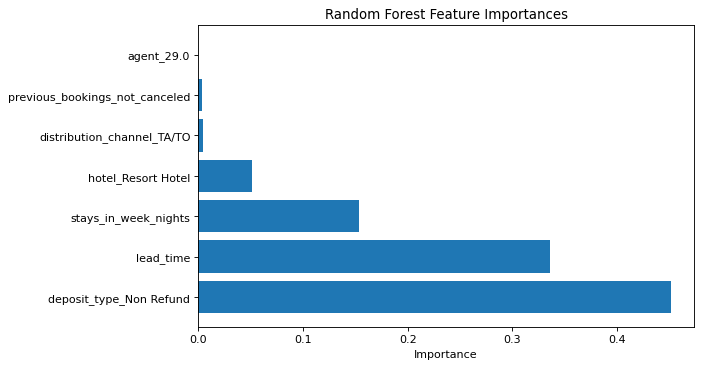

In [71]:
#Calculate the feature importances from the random forest model
importance = rf_model.feature_importances_
#Create a dataframe to store the feature importances
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
#Sort the dataframe by feature importance in descending order
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
#exclude features with 0 importance
feature_importance = feature_importance[feature_importance['Importance'] != 0] 
#create bar plot
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()

### Features of importance in the Random Forest Model

The selected features and their coefficients provide insight into the importance of variables in predicting hotel booking cancellations using the random forest model. 

Interestingly, all of the variables identified as important actually make people less likely to cancel their rooms. The variable with the highest coefficient value is deposit_type_Non Refund, which has a coefficient value of 0.4509, indicating its significance in predicting cancellations. Other important variables include lead_time and stays_in_week_nights, with coefficient values of 0.3358 and 0.1537, respectively. Additionally, the variable hotel_Resort Hotel is associated with a decreased likelihood of cancellations, as indicated by its positive coefficient value of 0.0514.

While variables such as distribution_channel_TA/TO and previous_bookings_not_canceled have relatively small positive coefficients, suggesting a weak association with cancellations, the agent_29.0 variable has a very small positive coefficient value and is not a significant predictor of cancellations. We can conclude that these variables are the most important in making the model accurate, as they are the only non-zero variables.

It's worth mentioning that the gini criterion was used to develop the random forest model, and although the entropy criterion was tested, the results were very similar.

## Analysis of ROC curve 

The ideal ROC curve would be one that moves towards the top left corner of the plot, but in this case, the curve doesn't quite do that. However, the AUC value of 0.62 is satisfactory, as any value above 0.5 indicates a better prediction than random chance. Therefore, the results are considered sufficient.

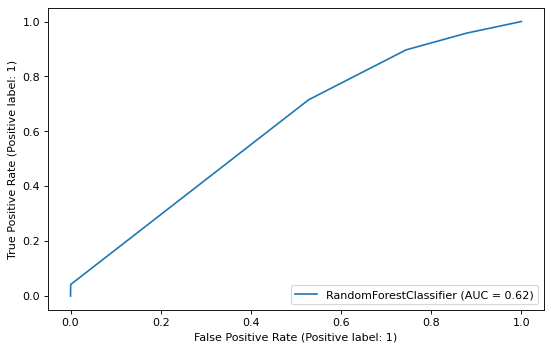

In [72]:
# Plot ROC curve for rf_model
plot_roc_curve(rf_model, X_test, y_test)
plt.show()


In [73]:
#code from labs

def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

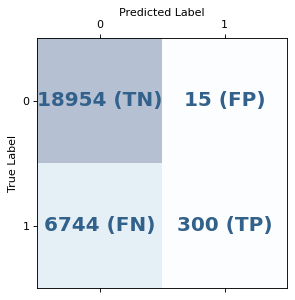

False Positive Rate (FPR): 0.001
Recall: 0.043
Precision: 0.952
F1 Score: 0.082


In [74]:
#code from labs 

# Make predictions on test set
y_pred = rf_model.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)

# Just a direct output for the confusion matrix  
confmat

LE = LabelEncoder()
LE.fit(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]
# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]
#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)


## 4. Discussion & Conclusions


###  The Final Model: Random Forest
The random forest model is designed to predict hotel cancellations and has undergone testing to evaluate its performance. While the model may have missed some cancellations, leading to a potential loss of revenue for the hotel, it also demonstrated a low false positive rate, which means that it didn't make many incorrect predictions of cancellations that didn't actually happen. With a precision score of 0.952, the model can be considered reliable and trustworthy for predicting hotel cancellations.

However, it's worth noting that the AUC score for the model was 0.62. AUC, or area under the curve, is a metric used to evaluate the overall performance of a model. An AUC of 0.62 suggests that the model's performance is only slightly better than random chance. While the high precision score suggests that the model can accurately identify most potential cancellations, the low AUC score indicates that the model may not be as effective at distinguishing between canceled and non-canceled reservations in general. 


### Conclusions and recommendations to 'Resort Hotel' and 'City Hotel'

Based on the importance of the features identified in our analysis, we can provide some recommendations to hotels on how to reduce the likelihood of cancellations. Firstly, lead time was found to be a key factor in predicting cancellations. Therefore, offering various early bird deals and promotions that incentivise customers to book in advance could be an effective strategy to reduce cancellations. When customers book their rooms earlier, they are more likely to have concrete plans and be less likely to cancel, as opposed to last-minute bookings that are more prone to cancellations.

Another important factor is the deposit type, with non-refundable deposits being associated with a higher likelihood of cancellations. However, it is important to strike a balance between protecting the hotel's revenue and not discouraging customers from booking. One way to achieve this balance could be to keep the non-refundable deposit cost reasonable while ensuring it still acts as a deterrent to cancellations.

Furthermore, our analysis showed that customers who book through Travel Agents and Tour Operators are less likely to cancel their bookings. Hence, developing stronger relationships with these channels could be a good strategy for hotels to attract more loyal customers and reduce cancellations. Hotels could consider developing reward policies for customers who haven't cancelled their bookings in the past, as this could incentivise customers to become more loyal to the hotel and make them less likely to cancel in the future.

In conclusion, by focusing on these key factors, 'Resort Hotel and 'City Hotel' can develop effective strategies to reduce cancellations and improve their revenue management.

### Further work

There is still room for further analysis of the data, particularly in addressing the presence of outliers that were observed in the 'Fitted vs Residual' plot and 'Actual vs Fitted' . To ensure that our model is as accurate and reliable as possible, additional investigation and remedial action may be required to mitigate the impact of these outliers. By taking a more thorough approach to analysing and cleaning the data, we can strengthen the robustness and validity of our model, and make more confident predictions based on its output

## 5. References

- Nuno Antonio, Ana de Almeida, Luis Nunes,
Hotel booking demand datasets,Volume 22,2019,Pages 41-49,ISSN 2352-3409,https://doi.org/10.1016/j.dib.2018.11.126.